#### cfDNA存放目录：/home/maweicheng/database/cfDNA
#### 癌症CT存放目录：/home/maweicheng/database/khct/patch_output/split_libs
#### 正常结节存放目录：/home/maweicheng/resgsca/database/3slice/64/nocancer

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import random

modalities = ["Frag", "CNV", "PFE", "NDR", "NDR2K"]
cf_base_dir = "../database/cfDNA"
ct_cancer_dir = "/home/maweicheng/database/khct/patch_output/split_libs"
ct_normal_dir = "/home/maweicheng/resgsca/database/3slice/64/nocancer"

save_train_path = os.path.join(cf_base_dir, "train.npz")
save_test_path = os.path.join(cf_base_dir, "test.npz")

# 1. 读取所有模态数据
cf_data = {}
for mod in modalities:
    df_norm = pd.read_csv(os.path.join(cf_base_dir, "normal", f"healthy_{mod}.csv"), index_col=0)
    df_can  = pd.read_csv(os.path.join(cf_base_dir, "cancer",  f"cancer_{mod}.csv"), index_col=0)
    df_norm = df_norm.fillna(df_norm.mean())
    df_can  = df_can.fillna(df_can.mean())
    cf_data[mod] = {"normal": df_norm, "cancer": df_can}
# 这个是删掉一些重复样本的版本
# 获取共同的 index（癌症部分）
to_remove = ['Lib-006', 'Lib-020', 'Lib-022', 'Lib-024', 'Lib-027', 'Lib-031', 'Lib-032', 'Lib-024', 'Lib-034', 'Lib-036', 'Lib-038', 'Lib-040'
             , 'Lib-042', 'Lib-044', 'Lib-046', 'Lib-048', 'Lib-050', 'Lib-050', 'Lib-051', 'Lib-054', 'Lib-056', 'Lib-057', 'Lib-058', 'Lib-063'
             , 'Lib-065', 'Lib-067', 'Lib-069', 'Lib-071', 'Lib-073', 'Lib-075', 'Lib-077', 'Lib-079', 'Lib-081', 'Lib-082', 'Lib-090', 'Lib-091'
             , 'Lib-092', 'Lib-093', 'Lib-094', 'Lib-095', 'Lib-096', 'Lib-097', 'Lib-110', 'Lib-121', 'Lib-122', 'Lib-123', 'Lib-137', 'Lib-138'
             , 'Lib-139', 'Lib-140', 'Lib-141', 'Lib-142', 'Lib-143', 'Lib-144', 'Lib-149', 'Lib-150', 'Lib-151', 'Lib-152', 'Lib-154', 'Lib-156'
             , 'Lib-158', 'Lib-160'
             ]
cancer_ids = cf_data["Frag"]["cancer"].index[~cf_data["Frag"]["cancer"].index.isin(to_remove)]
normal_ids = cf_data["Frag"]["normal"].index.tolist()

# 2. 处理 cancer 样本
X_cancer = {mod: [] for mod in modalities}
CT_cancer = []
y_cancer = []


for cid in cancer_ids:
    ct_pattern = os.path.join(ct_cancer_dir, cid, "*.npz")
    ct_files = glob.glob(ct_pattern)

    # 确保该病人目录下确实有一个 .npz 文件
    if len(ct_files) != 1:
        continue  # 无或多个 npz 文件都跳过

    ct_path = ct_files[0]
    try:
        ct_npz = np.load(ct_path)
        ct_data = ct_npz["data"]
        if ct_data.shape == (3, 64, 64):
            ct_data = np.transpose(ct_data, (1, 2, 0)) 
    except Exception as e:
        print(f"[Warning] Failed to load CT for {cid}: {e}")
        continue

    # 检查 cfDNA 模态是否齐全
    valid = all(cid in cf_data[mod]["cancer"].index for mod in modalities)
    if not valid:
        continue

    # 添加数据
    for mod in modalities:
        X_cancer[mod].append(cf_data[mod]["cancer"].loc[cid].values.astype(np.float32))
    CT_cancer.append(ct_data.astype(np.float32))
    y_cancer.append(1)

# 3. 处理 normal 样本
X_normal = {mod: [] for mod in modalities}
CT_normal = []
y_normal = []

used_nocancer = set()
available_ct_files = sorted(os.listdir(ct_normal_dir))

for nid in normal_ids:
    # 随机选择未使用的 CT 文件
    candidates = list(set(available_ct_files) - used_nocancer)
    if not candidates:
        break  # 不够用了
    selected = random.choice(candidates)
    used_nocancer.add(selected)
    ct_path = os.path.join(ct_normal_dir, selected)
    try:
        ct_npz = np.load(ct_path)
        ct_data = ct_npz["data"]
    except:
        continue

    for mod in modalities:
        X_normal[mod].append(cf_data[mod]["normal"].loc[nid].values.astype(np.float32))
    CT_normal.append(ct_data.astype(np.float32))
    y_normal.append(0)

# 4. 组装训练与测试集（90% 训练 + 10% 测试，按顺序切分）
def split_data(X_dict, CT_list, y_list):
    n = len(y_list)
    split = int(n * 0.1)
    idx_test, idx_train = np.arange(split), np.arange(split, n)

    def subset(data, idx):
        return [np.array(data[i]) for i in idx]

    train = {mod: np.stack(subset(X_dict[mod], idx_train)) for mod in modalities}
    test  = {mod: np.stack(subset(X_dict[mod], idx_test))  for mod in modalities}
    train["CT"] = np.stack(subset(CT_list, idx_train))
    test["CT"]  = np.stack(subset(CT_list, idx_test))
    train["y"]  = np.array([y_list[i] for i in idx_train])
    test["y"]   = np.array([y_list[i] for i in idx_test])
    return train, test

print(f"癌症样本数: {len(y_cancer)}")
print(f"正常样本数: {len(y_normal)}")

train_can, test_can = split_data(X_cancer, CT_cancer, y_cancer)
train_nor, test_nor = split_data(X_normal, CT_normal, y_normal)

# 合并
train_all = {key: np.concatenate([train_can[key], train_nor[key]]) for key in train_can}
test_all  = {key: np.concatenate([test_can[key], test_nor[key]])   for key in test_can}

# 5. 保存
np.savez_compressed(save_train_path, **train_all)
np.savez_compressed(save_test_path,  **test_all)
print("已保存：", save_train_path, save_test_path)

癌症样本数: 40
正常样本数: 340
已保存： ../database/cfDNA/train.npz ../database/cfDNA/test.npz


In [7]:
import os
import glob
import pandas as pd
import numpy as np
import random

modalities = ["Frag", "CNV", "PFE", "NDR", "NDR2K"]
cf_base_dir = "/home/maweicheng/database/cfDNA"
ct_cancer_dir = "/home/maweicheng/database/khct/patch_output/split_libs"
ct_normal_dir = "/home/maweicheng/resgsca/database/3slice/64/nocancer"

save_train_path = os.path.join(cf_base_dir, "cancer_and_normal/train.npz")
save_test_path = os.path.join(cf_base_dir, "cancer_and_normal/test.npz")

# 1. 读取所有模态数据
cf_data = {}
for mod in modalities:
    df_norm = pd.read_csv(os.path.join(cf_base_dir, "normal", f"healthy_{mod}.csv"), index_col=0)
    df_can  = pd.read_csv(os.path.join(cf_base_dir, "cancer",  f"cancer_{mod}.csv"), index_col=0)
    df_norm = df_norm.fillna(df_norm.mean())
    df_can  = df_can.fillna(df_can.mean())
    cf_data[mod] = {"normal": df_norm, "cancer": df_can}

# 获取共同的 index（癌症部分）
cancer_ids = cf_data["Frag"]["cancer"].index.tolist()
normal_ids = cf_data["Frag"]["normal"].index.tolist()


# 2. 处理 cancer 样本
X_cancer = {mod: [] for mod in modalities}
CT_cancer = []
y_cancer = []


for cid in cancer_ids:
    ct_pattern = os.path.join(ct_cancer_dir, cid, "*.npz")
    ct_files = glob.glob(ct_pattern)

    # 确保该病人目录下确实有一个 .npz 文件
    if len(ct_files) != 1:
        continue  # 无或多个 npz 文件都跳过

    ct_path = ct_files[0]
    try:
        ct_npz = np.load(ct_path)
        ct_data = ct_npz["data"]
        if ct_data.shape == (3, 64, 64):
            ct_data = np.transpose(ct_data, (1, 2, 0)) 
    except Exception as e:
        print(f"[Warning] Failed to load CT for {cid}: {e}")
        continue

    # 检查 cfDNA 模态是否齐全
    valid = all(cid in cf_data[mod]["cancer"].index for mod in modalities)
    if not valid:
        continue

    # 添加数据
    for mod in modalities:
        X_cancer[mod].append(cf_data[mod]["cancer"].loc[cid].values.astype(np.float32))
    CT_cancer.append(ct_data.astype(np.float32))
    y_cancer.append(1)

# 3. 处理 normal 样本
X_normal = {mod: [] for mod in modalities}
CT_normal = []
y_normal = []

used_nocancer = set()
available_ct_files = sorted(os.listdir(ct_normal_dir))

for nid in normal_ids:
    # 随机选择未使用的 CT 文件
    candidates = list(set(available_ct_files) - used_nocancer)
    if not candidates:
        break  # 不够用了
    selected = random.choice(candidates)
    used_nocancer.add(selected)
    ct_path = os.path.join(ct_normal_dir, selected)
    try:
        ct_npz = np.load(ct_path)
        ct_data = ct_npz["data"]
    except:
        continue

    for mod in modalities:
        X_normal[mod].append(cf_data[mod]["normal"].loc[nid].values.astype(np.float32))
    CT_normal.append(ct_data.astype(np.float32))
    y_normal.append(0)

# 4. 组装训练与测试集（80% 训练 + 20% 测试，按顺序切分）
def split_data(X_dict, CT_list, y_list):
    n = len(y_list)
    split = int(n * 0.2)
    idx_test, idx_train = np.arange(split), np.arange(split, n)

    def subset(data, idx):
        return [np.array(data[i]) for i in idx]

    train = {mod: np.stack(subset(X_dict[mod], idx_train)) for mod in modalities}
    test  = {mod: np.stack(subset(X_dict[mod], idx_test))  for mod in modalities}
    train["CT"] = np.stack(subset(CT_list, idx_train))
    test["CT"]  = np.stack(subset(CT_list, idx_test))
    train["y"]  = np.array([y_list[i] for i in idx_train])
    test["y"]   = np.array([y_list[i] for i in idx_test])
    return train, test

print(f"癌症样本数: {len(y_cancer)}")
print(f"正常样本数: {len(y_normal)}")

train_can, test_can = split_data(X_cancer, CT_cancer, y_cancer)
train_nor, test_nor = split_data(X_normal, CT_normal, y_normal)

# 合并
train_all = {key: np.concatenate([train_can[key], train_nor[key]]) for key in train_can}
test_all  = {key: np.concatenate([test_can[key], test_nor[key]])   for key in test_can}

# 5. 保存
np.savez_compressed(save_train_path, **train_all)
np.savez_compressed(save_test_path,  **test_all)
print("已保存：", save_train_path, save_test_path)

癌症样本数: 79
正常样本数: 340
已保存： /home/maweicheng/database/cfDNA/cancer_and_normal/train.npz /home/maweicheng/database/cfDNA/cancer_and_normal/test.npz


# 下面这个加了id

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

modalities = ["Frag", "CNV", "PFE", "NDR", "NDR2K"]
cf_base_dir = "../database/cfDNA"
ct_cancer_dir = "/home/maweicheng/database/khct/patch_output/split_libs"
ct_normal_dir = "/home/maweicheng/resgsca/database/3slice/64/nocancer"

save_train_path = os.path.join(cf_base_dir, "train.npz")
save_test_path = os.path.join(cf_base_dir, "test.npz")

# 1. 读取所有模态数据
cf_data = {}
for mod in modalities:
    df_norm = pd.read_csv(os.path.join(cf_base_dir, "normal", f"healthy_{mod}.csv"), index_col=0)
    df_can  = pd.read_csv(os.path.join(cf_base_dir, "cancer",  f"cancer_{mod}.csv"), index_col=0)
    df_norm = df_norm.fillna(df_norm.mean())
    df_can  = df_can.fillna(df_can.mean())
    cf_data[mod] = {"normal": df_norm, "cancer": df_can}

# 获取 index
cancer_ids = cf_data["Frag"]["cancer"].index.tolist()
normal_ids = cf_data["Frag"]["normal"].index.tolist()

# 从 normal_ids 中随机抽取与 cancer_ids 相同数量的样本
random.seed(51)  # 确保结果可复现
normal_ids = random.sample(normal_ids, len(cancer_ids))
# 2. 处理 cancer 样本
X_cancer = {mod: [] for mod in modalities}
CT_cancer = []
y_cancer = []
id_cancer = []

for cid in cancer_ids:
    ct_pattern = os.path.join(ct_cancer_dir, cid, "*.npz")
    ct_files = glob.glob(ct_pattern)
    if len(ct_files) != 1:
        continue
    ct_path = ct_files[0]
    try:
        ct_npz = np.load(ct_path)
        ct_data = ct_npz["data"]
        if ct_data.shape == (3, 64, 64):
            ct_data = np.transpose(ct_data, (1, 2, 0))
    except Exception as e:
        print(f"[Warning] Failed to load CT for {cid}: {e}")
        continue

    valid = all(cid in cf_data[mod]["cancer"].index for mod in modalities)
    if not valid:
        continue

    for mod in modalities:
        X_cancer[mod].append(cf_data[mod]["cancer"].loc[cid].values.astype(np.float32))

    plt.imshow(ct_data / np.max(ct_data))  # 归一化展示
    plt.title(f"Cancer ID: {cid}")
    plt.axis('off')
    plt.show()
    CT_cancer.append(ct_data.astype(np.float32))
    y_cancer.append(1)
    id_cancer.append(cid)

# 3. 处理 normal 样本
X_normal = {mod: [] for mod in modalities}
CT_normal = []
y_normal = []
id_normal = []

used_nocancer = set()
available_ct_files = sorted(os.listdir(ct_normal_dir))
print("开始处理正常样本")
for nid in normal_ids:
    candidates = list(set(available_ct_files) - used_nocancer)
    if not candidates:
        break
    selected = random.choice(candidates)
    used_nocancer.add(selected)
    ct_path = os.path.join(ct_normal_dir, selected)
    try:
        ct_npz = np.load(ct_path)
        ct_data = ct_npz["data"]
    except:
        continue

    for mod in modalities:
        X_normal[mod].append(cf_data[mod]["normal"].loc[nid].values.astype(np.float32))
    
    plt.imshow(ct_data / np.max(ct_data))  # 归一化展示
    plt.title(f"Cancer ID: {nid}")
    plt.axis('off')
    plt.show()
    CT_normal.append(ct_data.astype(np.float32))
    y_normal.append(0)
    id_normal.append(nid)  # 去掉 .npz 后缀

# 4. 组装训练与测试集（90% 训练 + 10% 测试）
def split_data(X_dict, CT_list, y_list, id_list):
    n = len(y_list)
    split = int(n * 0.1)
    idx_test, idx_train = np.arange(split), np.arange(split, n)

    def subset(data, idx):
        return [data[i] for i in idx]

    train = {mod: np.stack(subset(X_dict[mod], idx_train)) for mod in modalities}
    test  = {mod: np.stack(subset(X_dict[mod], idx_test))  for mod in modalities}
    train["CT"] = np.stack(subset(CT_list, idx_train))
    test["CT"]  = np.stack(subset(CT_list, idx_test))
    train["y"]  = np.array([y_list[i] for i in idx_train])
    test["y"]   = np.array([y_list[i] for i in idx_test])
    train["id"] = np.array([id_list[i] for i in idx_train])
    test["id"]  = np.array([id_list[i] for i in idx_test])
    return train, test

print(f"癌症样本数: {len(y_cancer)}")
print(f"正常样本数: {len(y_normal)}")

train_can, test_can = split_data(X_cancer, CT_cancer, y_cancer, id_cancer)
train_nor, test_nor = split_data(X_normal, CT_normal, y_normal, id_normal)

# 合并
train_all = {key: np.concatenate([train_can[key], train_nor[key]]) for key in train_can}
test_all  = {key: np.concatenate([test_can[key], test_nor[key]])   for key in test_can}

# 5. 保存
np.savez_compressed(save_train_path, **train_all)
np.savez_compressed(save_test_path,  **test_all)
print("已保存：", save_train_path, save_test_path)

# 这儿是恶性良性的，我晕

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

# 参数设定
modalities = ["Frag", "CNV", "PFE", "NDR", "NDR2K"]
cf_base_dir = "/home/maweicheng/database/cfDNA"
ct_base_dir = "/home/maweicheng/database/khct/patch_output/split_libs_new"
save_train_path = os.path.join(cf_base_dir, "cancer_and_benign/train.npz")
save_test_path = os.path.join(cf_base_dir, "cancer_and_benign/test.npz")

# Library ID 列表
cancer_ids = ["Lib-004", "Lib-019", "Lib-020", "Lib-021", "Lib-022", "Lib-025", "Lib-028", "Lib-032", "Lib-037", "Lib-038", "Lib-039", "Lib-040", "Lib-066",
              "Lib-067", "Lib-068", "Lib-069", "Lib-076", "Lib-077", "Lib-082", "Lib-083", "Lib-086", "Lib-087", "Lib-088", "Lib-090", "Lib-093", "Lib-094",
              "Lib-107", "Lib-108", "Lib-109", "Lib-110", "Lib-121", "Lib-122", "Lib-123", "Lib-124", "Lib-126", "Lib-128", "Lib-130", "Lib-131", "Lib-137",
              "Lib-140", "Lib-142", "Lib-143", "Lib-145", "Lib-149", "Lib-150", "Lib-157", "Lib-158", "Lib-159", "Lib-160"]

benign_ids = ["Lib-005", "Lib-006", "Lib-026", "Lib-027", "Lib-030", "Lib-031", "Lib-033", "Lib-034", "Lib-035", "Lib-036", "Lib-064", "Lib-065", "Lib-070",
              "Lib-071", "Lib-074", "Lib-075", "Lib-084", "Lib-085", "Lib-089", "Lib-091", "Lib-092", "Lib-095", "Lib-096", "Lib-097", "Lib-125", "Lib-132",
              "Lib-138", "Lib-144", "Lib-147", "Lib-148", "Lib-151", "Lib-152", "Lib-153", "Lib-154"]

# 1. 读取所有模态数据（合并癌症/良性）
cf_data = {}
for mod in modalities:
    df_all = pd.read_csv(os.path.join(cf_base_dir,"cancer", f"cancer_{mod}.csv"), index_col=0)
    df_all = df_all.fillna(df_all.mean())  # 缺失值填充
    cf_data[mod] = df_all

# 通用处理函数
def process_samples(id_list, label):
    X = {mod: [] for mod in modalities}
    CT = []
    y = []
    ids = []

    for pid in id_list:
        # 加载 CT 图像
        ct_pattern = os.path.join(ct_base_dir, pid, "*.npz")
        ct_files = glob.glob(ct_pattern)
        if len(ct_files) != 1:
            print(f"[Skip] {pid} CT 文件数量不唯一")
            continue

        try:
            ct_npz = np.load(ct_files[0])
            ct_data = ct_npz["data"]
            if ct_data.shape == (3, 64, 64):
                ct_data = np.transpose(ct_data, (1, 2, 0))  # (64, 64, 3)
        except Exception as e:
            print(f"[Warning] CT 加载失败 {pid}: {e}")
            continue

        # 检查 cfDNA 是否都有
        if not all(pid in cf_data[mod].index for mod in modalities):
            print(f"[Skip] {pid} 缺失模态数据")
            continue

        # 添加数据
        for mod in modalities:
            X[mod].append(cf_data[mod].loc[pid].values.astype(np.float32))
        CT.append(ct_data.astype(np.float32))
        y.append(label)
        ids.append(pid)

        # 可视化
        plt.imshow(ct_data / np.max(ct_data))
        plt.title(f"{'Cancer' if label == 1 else 'Benign'} ID: {pid}")
        plt.axis('off')
        plt.show()

    return X, CT, y, ids

# 2. 分别处理癌症/良性
X_cancer, CT_cancer, y_cancer, id_cancer = process_samples(cancer_ids, label=1)
X_benign, CT_benign, y_benign, id_benign = process_samples(benign_ids, label=0)

print(f"癌症样本数: {len(y_cancer)}")
print(f"良性样本数: {len(y_benign)}")

# 3. 训练测试划分函数
def split_data(X_dict, CT_list, y_list, id_list):
    n = len(y_list)
    split = int(n * 0.3)
    idx_test, idx_train = np.arange(split), np.arange(split, n)

    def subset(data, idx): return [data[i] for i in idx]

    train = {mod: np.stack(subset(X_dict[mod], idx_train)) for mod in modalities}
    test = {mod: np.stack(subset(X_dict[mod], idx_test)) for mod in modalities}
    train["CT"] = np.stack(subset(CT_list, idx_train))
    test["CT"] = np.stack(subset(CT_list, idx_test))
    train["y"] = np.array([y_list[i] for i in idx_train])
    test["y"] = np.array([y_list[i] for i in idx_test])
    train["id"] = np.array([id_list[i] for i in idx_train])
    test["id"] = np.array([id_list[i] for i in idx_test])
    return train, test

# 4. 拆分并合并训练测试集
train_can, test_can = split_data(X_cancer, CT_cancer, y_cancer, id_cancer)
train_ben, test_ben = split_data(X_benign, CT_benign, y_benign, id_benign)
train_all = {key: np.concatenate([train_can[key], train_ben[key]]) for key in train_can}
test_all = {key: np.concatenate([test_can[key], test_ben[key]]) for key in test_can}

# 5. 保存为 .npz
np.savez_compressed(save_train_path, **train_all)
np.savez_compressed(save_test_path, **test_all)
print("✅ 数据保存完成:", save_train_path, save_test_path)

# 下面是分亚型

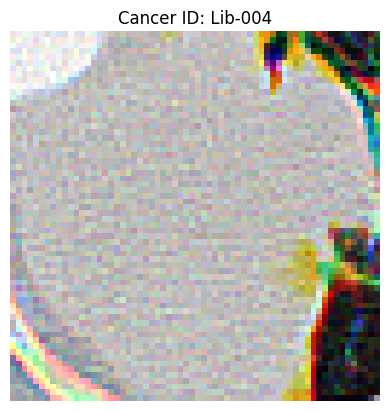

[Skip] Lib-019 CT 文件数量不唯一
[Skip] Lib-020 CT 文件数量不唯一


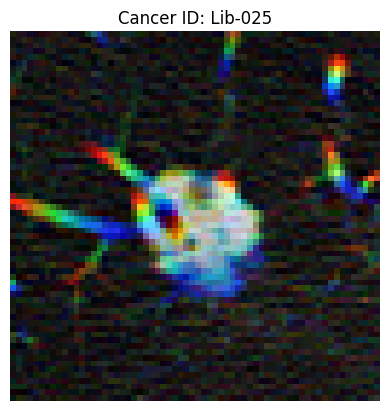

[Skip] Lib-028 CT 文件数量不唯一
[Skip] Lib-037 CT 文件数量不唯一
[Skip] Lib-038 CT 文件数量不唯一
[Skip] Lib-039 CT 文件数量不唯一
[Skip] Lib-040 CT 文件数量不唯一


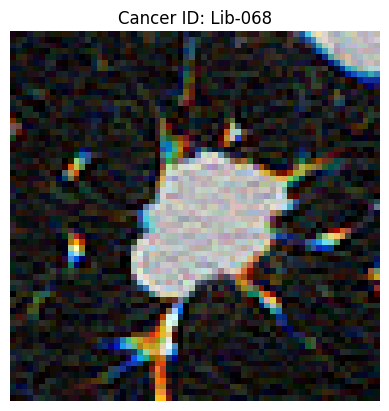

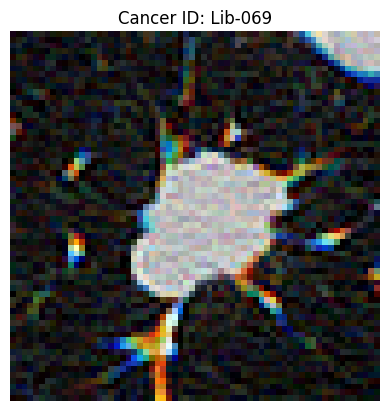

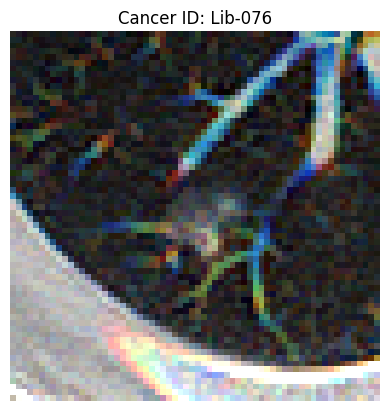

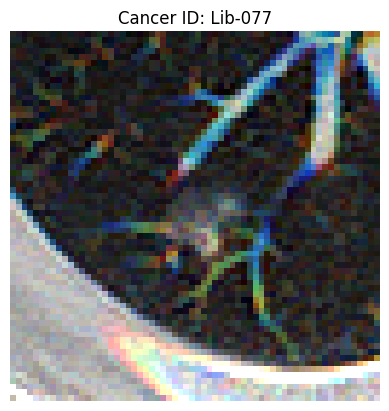

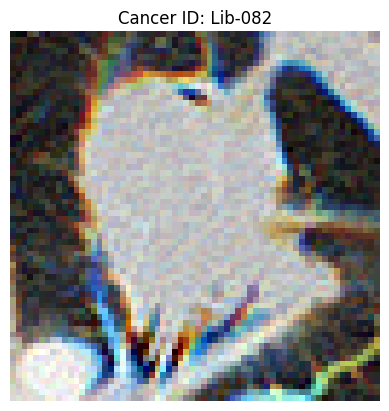

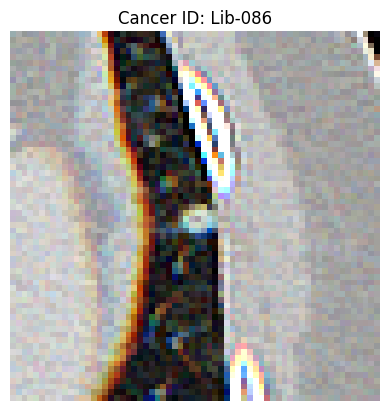

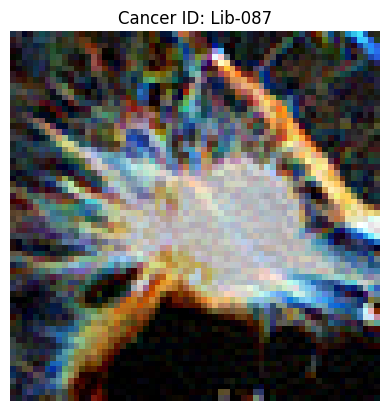

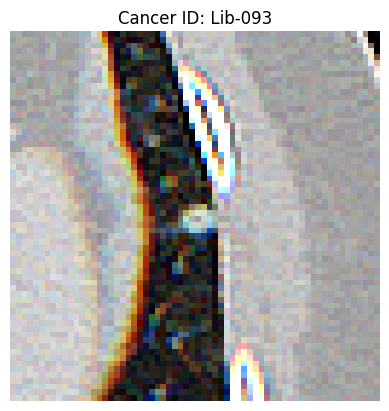

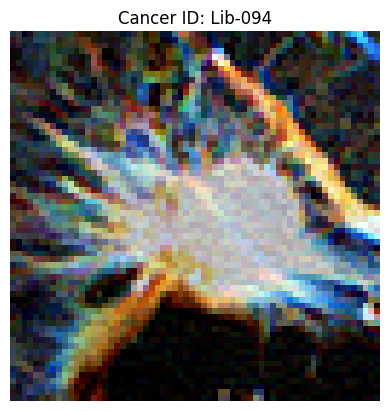

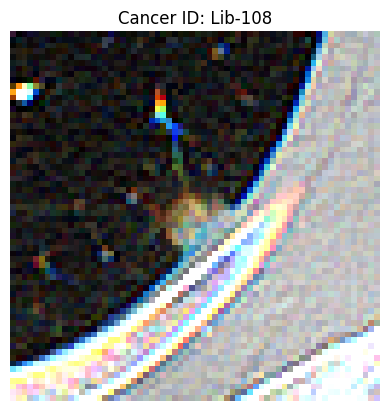

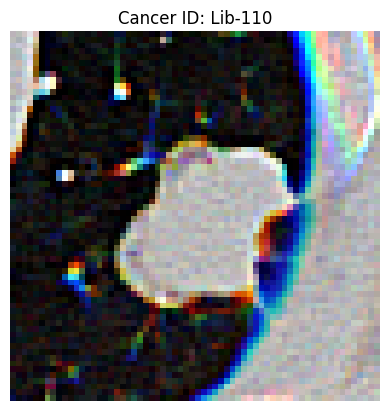

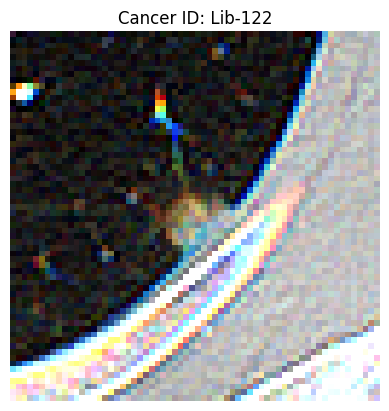

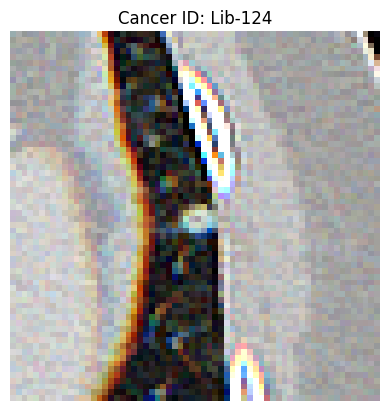

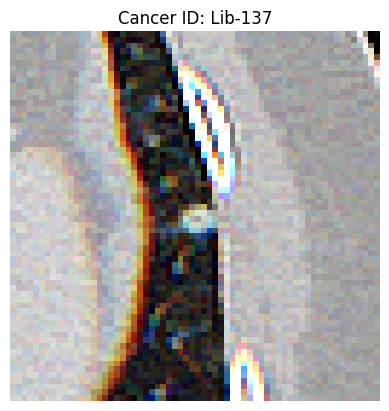

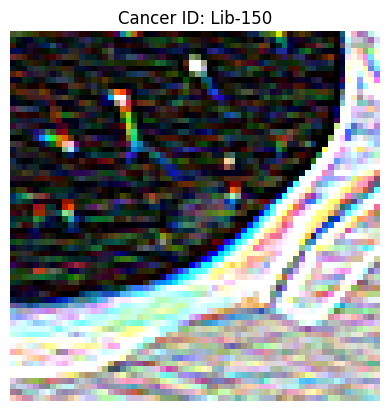

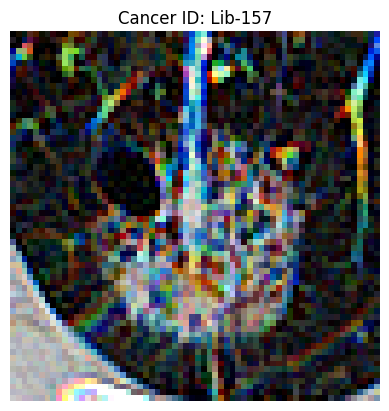

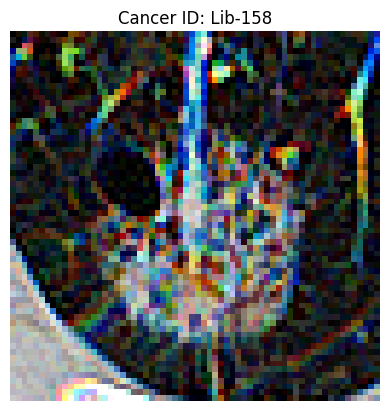

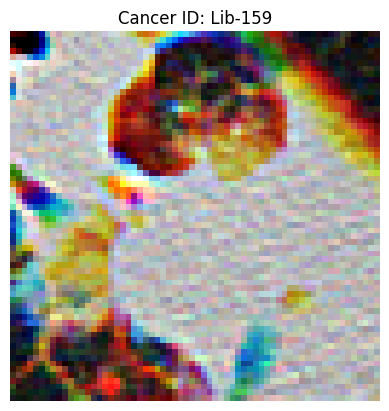

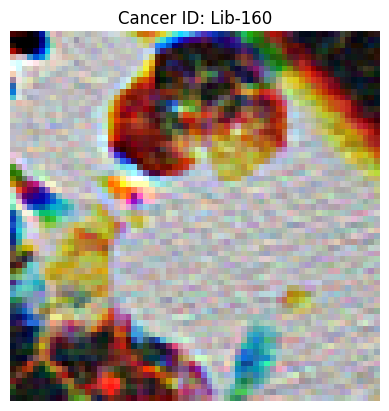

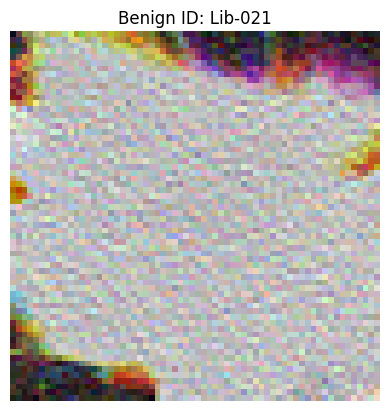

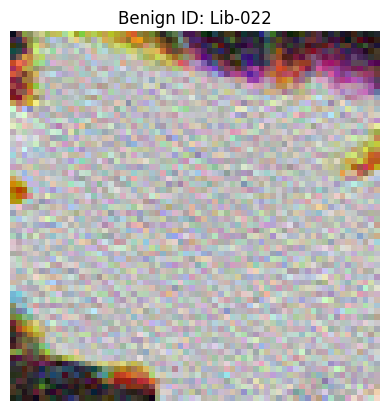

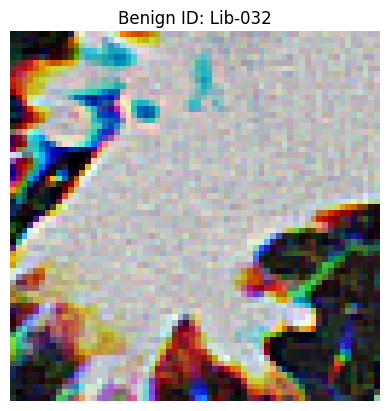

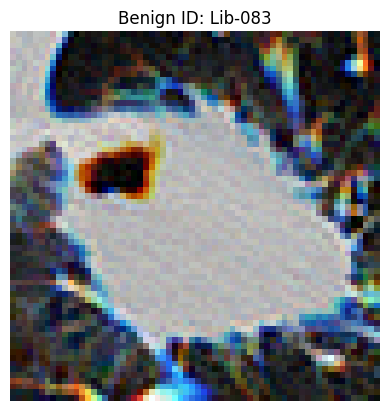

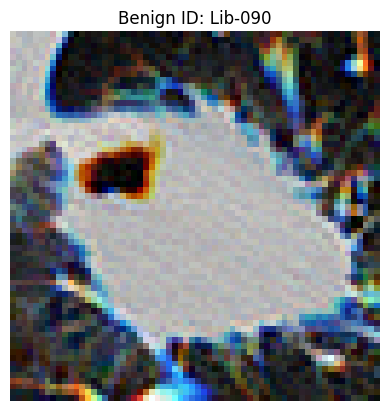

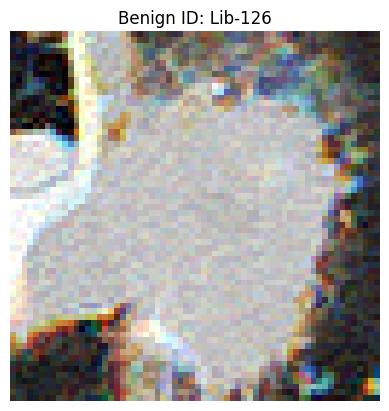

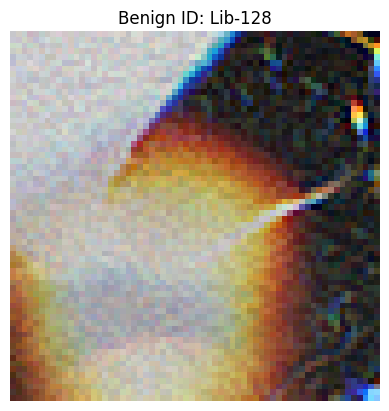

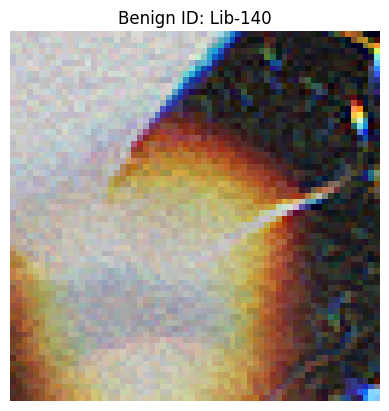

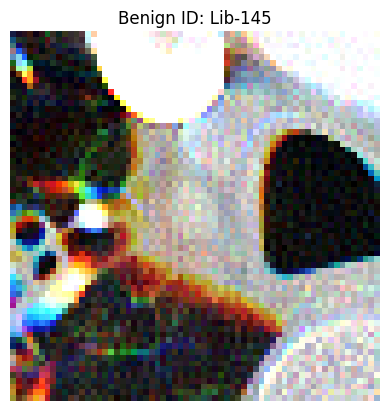

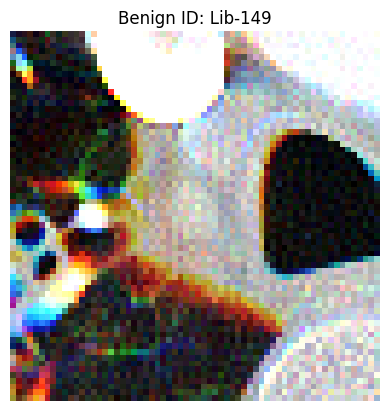

癌症样本数: 21
良性样本数: 10
✅ 数据保存完成: /home/maweicheng/database/cfDNA/subtype/train.npz /home/maweicheng/database/cfDNA/subtype/test.npz


In [5]:
import os
import glob
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

# 参数设定
modalities = ["Frag", "CNV", "PFE", "NDR", "NDR2K"]
cf_base_dir = "/home/maweicheng/database/cfDNA"
ct_base_dir = "/home/maweicheng/database/khct/patch_output/split_libs_new"
save_train_path = os.path.join(cf_base_dir, "subtype/train.npz")
save_test_path = os.path.join(cf_base_dir, "subtype/test.npz")

# Library ID 列表
LUAD_ids = ["Lib-004","Lib-019", "Lib-020", "Lib-025", "Lib-028", "Lib-037", "Lib-038", "Lib-039", "Lib-040", "Lib-068", "Lib-069", "Lib-076",
"Lib-077", "Lib-082", "Lib-086", "Lib-087", "Lib-093", "Lib-094", "Lib-108", "Lib-110", "Lib-122", "Lib-124", "Lib-137", "Lib-150",
"Lib-157", "Lib-158", "Lib-159", "Lib-160"]

LUSC_ids = ["Lib-021", "Lib-022", "Lib-032", "Lib-083", "Lib-090", "Lib-126", "Lib-128", "Lib-140", "Lib-145", "Lib-149"]

# 1. 读取所有模态数据（合并癌症/良性）
cf_data = {}
for mod in modalities:
    df_all = pd.read_csv(os.path.join(cf_base_dir,"cancer", f"cancer_{mod}.csv"), index_col=0)
    df_all = df_all.fillna(df_all.mean())  # 缺失值填充
    cf_data[mod] = df_all

# 通用处理函数
def process_samples(id_list, label):
    X = {mod: [] for mod in modalities}
    CT = []
    y = []
    ids = []

    for pid in id_list:
        # 加载 CT 图像
        ct_pattern = os.path.join(ct_base_dir, pid, "*.npz")
        ct_files = glob.glob(ct_pattern)
        if len(ct_files) != 1:
            print(f"[Skip] {pid} CT 文件数量不唯一")
            continue

        try:
            ct_npz = np.load(ct_files[0])
            ct_data = ct_npz["data"]
            if ct_data.shape == (3, 64, 64):
                ct_data = np.transpose(ct_data, (1, 2, 0))  # (64, 64, 3)
        except Exception as e:
            print(f"[Warning] CT 加载失败 {pid}: {e}")
            continue

        # 检查 cfDNA 是否都有
        if not all(pid in cf_data[mod].index for mod in modalities):
            print(f"[Skip] {pid} 缺失模态数据")
            continue

        # 添加数据
        for mod in modalities:
            X[mod].append(cf_data[mod].loc[pid].values.astype(np.float32))
        CT.append(ct_data.astype(np.float32))
        y.append(label)
        ids.append(pid)

        # 可视化
        plt.imshow(ct_data / np.max(ct_data))
        plt.title(f"{'Cancer' if label == 1 else 'Benign'} ID: {pid}")
        plt.axis('off')
        plt.show()

    return X, CT, y, ids

# 2. 分别处理癌症/良性
X_cancer, CT_cancer, y_cancer, id_cancer = process_samples(LUAD_ids, label=1)
X_benign, CT_benign, y_benign, id_benign = process_samples(LUSC_ids, label=0)

print(f"癌症样本数: {len(y_cancer)}")
print(f"良性样本数: {len(y_benign)}")

# 3. 训练测试划分函数
def split_data(X_dict, CT_list, y_list, id_list):
    n = len(y_list)
    split = int(n * 0.3)
    idx_test, idx_train = np.arange(split), np.arange(split, n)

    def subset(data, idx): return [data[i] for i in idx]

    train = {mod: np.stack(subset(X_dict[mod], idx_train)) for mod in modalities}
    test = {mod: np.stack(subset(X_dict[mod], idx_test)) for mod in modalities}
    train["CT"] = np.stack(subset(CT_list, idx_train))
    test["CT"] = np.stack(subset(CT_list, idx_test))
    train["y"] = np.array([y_list[i] for i in idx_train])
    test["y"] = np.array([y_list[i] for i in idx_test])
    train["id"] = np.array([id_list[i] for i in idx_train])
    test["id"] = np.array([id_list[i] for i in idx_test])
    return train, test

# 4. 拆分并合并训练测试集
train_can, test_can = split_data(X_cancer, CT_cancer, y_cancer, id_cancer)
train_ben, test_ben = split_data(X_benign, CT_benign, y_benign, id_benign)
train_all = {key: np.concatenate([train_can[key], train_ben[key]]) for key in train_can}
test_all = {key: np.concatenate([test_can[key], test_ben[key]]) for key in test_can}

# 5. 保存为 .npz
np.savez_compressed(save_train_path, **train_all)
np.savez_compressed(save_test_path, **test_all)
print("✅ 数据保存完成:", save_train_path, save_test_path)